In [ ]:
import cv2
import numpy as np
import os
import csv
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

In [34]:
def count_steps(image, debug=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_kernel = max(3, int(min(image.shape[:2]) * 0.005)//2 * 2 + 1) # kernel en fonction de 0.5% de la dimension la plus petite
    blurred = cv2.GaussianBlur(gray, (blur_kernel, blur_kernel), 0) # gaussien adaptatif avec kernel adaptatif

    low_percentile = np.percentile(blurred, 5)
    clip_limit = max(1.0, 2.0 + (low_percentile/255) * 3)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8)) # egalisation adaptatif
    equalized = clahe.apply(blurred)

    th_value, _ = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # seuillage avec Otsu
    edges = cv2.Canny(equalized, int(0.4*th_value), int(th_value)) # Canny avec 40% et 100% de la valeur d'Otsu pour les seuils bas et haut
    
    horizontal_profile = np.sum(edges, axis=1)
    window_size = max(11, int(len(horizontal_profile)*0.1)//2 * 2 + 1) # fenetre de 10% du profil
    smoothed = savgol_filter(horizontal_profile, window_size, 3) # lissage du profil

    # detection des pics
    derivative = np.gradient(smoothed)
    min_peak_dist = max(10, image.shape[0]//20)
    prominence = np.std(derivative) * 0.5 
    pos_peaks, _ = find_peaks(derivative, prominence=prominence, distance=min_peak_dist)
    neg_peaks, _ = find_peaks(-derivative, prominence=prominence, distance=min_peak_dist)

    # compte les marches avec les pics du profil
    valid_pairs = []
    for p_pos in pos_peaks:
        candidates = neg_peaks[neg_peaks > p_pos]
        if len(candidates) > 0:
            p_neg = candidates[0]
            if (p_neg - p_pos) < image.shape[0]/15:
                valid_pairs.append((p_pos, p_neg))
    
    if debug:
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(edges, cmap="gray")
        plt.title(f"Contours")
        
        plt.subplot(122)
        plt.plot(smoothed)
        plt.title(f"Marches detectees: {len(valid_pairs)}")
        plt.show()
    
    return len(valid_pairs)


def metrics(results):
    total = 0
    total_correct = 0
    total_error = 0
    
    for _, _, _, is_correct, error in results:
        total_error += error
        total_correct += int(is_correct)
        total += 1     

    if total > 0:
        accuracy = total_correct/total
        mean_error = total_error/total
        print(f"Accuracy : {accuracy * 100:.2f}%")
        print(f"Erreur moyenne (MAE) : {mean_error:.2f} marches")


def save_results(results):
    with open('resultats.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Image', 'Marches attendues', 'Marches detectees', 'Correct', 'Erreur'])
        writer.writerows(results)
    print(f"Resultats dans resultats.csv")


def plot_results(results):
    expected = [row[1] for row in results]
    predicted = [row[2] for row in results]
    
    mean_expected = np.mean(expected)
    mean_predicted = np.mean(predicted)  

    plt.figure(figsize=(20, 7))

    x = np.arange(len(expected))

    plt.plot(x, expected, 'go-', label='Expected')
    plt.plot(x, predicted, 'rs-', label='Predicted')
    
    # ligne des moyennes
    plt.axhline(mean_expected, color='green', linestyle='--', label='Expected mean')
    plt.axhline(mean_predicted, color='red', linestyle='--', label='Predicted mean')
    
    plt.xticks(x, x, ha='right')
    plt.ylabel('Nombre de marches')
    plt.title('Comparaison des resultats')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.text(len(x)+0.5, mean_expected+0.5, f'{mean_expected:.1f}', color='green', va='center', ha='left')
    plt.text(len(x)+0.5, mean_predicted+0.5, f'{mean_predicted:.1f}', color='red', va='center', ha='left')
    
    plt.show()

Accuracy : 22.62%
Erreur moyenne (MAE) : 4.06 marches
Resultats dans resultats.csv


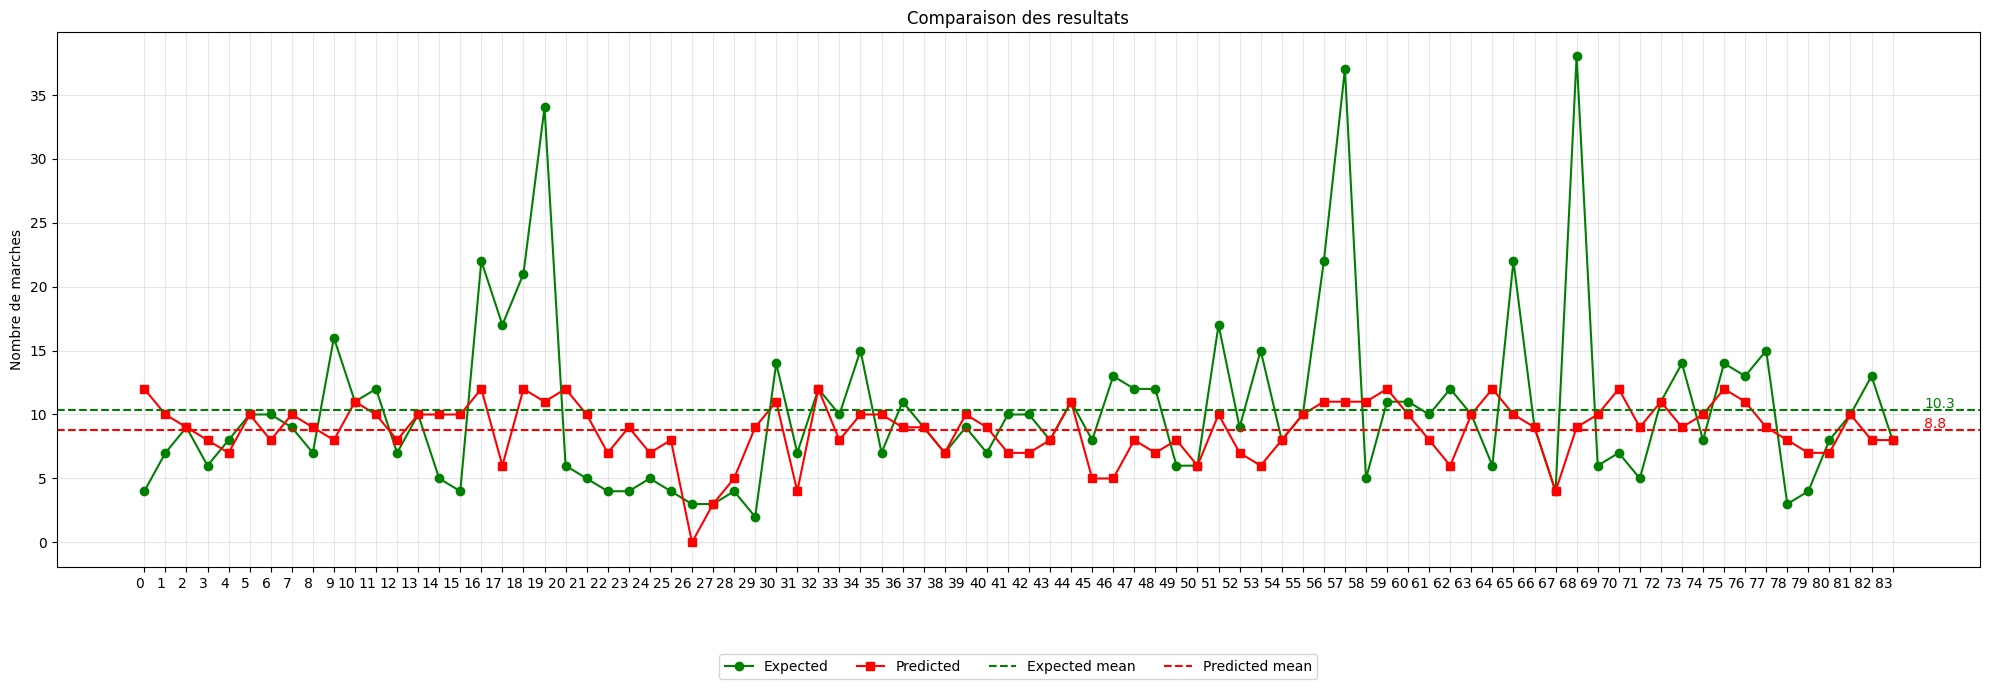

In [ ]:
image_folder = 'images'
csv_file = 'data annotations - Feuille 1.csv'
debug = True
save = True

results = []
total_correct = 0
total_error = 0
total = 0

with open(csv_file, mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)

    # on ignore les 2 premieres ligens
    next(reader)
    next(reader)
    
    for row in reader:
        if len(row) < 2 or not row[0]:  # ignorer les lignes vides ou incompletes
            continue
        
        image_name = row[0]
        expected = int(row[1])
        image_path = os.path.join(image_folder, image_name)
        if not os.path.exists(image_path):
            #print(f"Erreur : fichier introuvable {image_name}, pas bien :(")
            continue
        
        # detection des marches
        image = cv2.imread(image_path)
        pred = count_steps(image, debug=debug)

        error = abs(pred - expected)
        is_correct = (error == 0)
        results.append([image_name, expected, pred, is_correct, error])
        #print(f"Image : {image_name} | attendues : {expected} | detectees : {pred} | Correct : {is_correct} | Erreur : {error} marches")

metrics(results)
if save:
    save_results(results)
plot_results(results)
